In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
#data_url = 'http://www.ndbc.noaa.gov/data/5day2/46022_5day.txt'
data_url = 'http://www.ndbc.noaa.gov/data/realtime2/46022.txt'

# Set the number of hours to report.
LAST_HOURS = 24
buoy22_df = pd.read_csv(data_url, header=0, skiprows=[1], nrows=LAST_HOURS, sep='\s+', na_values=['MM', -99])
buoy22_df.head()

,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE
0,2016,10,27,20,50,160,5.0,6.0,2.3,16,8.9,282,1012.8,13.9,14.2,12.3,NaN,0.0,NaN
1,2016,10,27,19,50,200,2.0,3.0,2.4,16,8.0,292,1013.3,14.0,14.2,11.9,NaN,1.1,NaN
2,2016,10,27,18,50,130,6.0,8.0,2.2,16,6.9,280,1013.3,13.9,14.1,11.8,NaN,-0.0,NaN
3,2016,10,27,17,50,100,9.0,11.0,2.4,9,6.7,214,1013.0,12.9,14.1,11.5,NaN,-0.0,NaN
4,2016,10,27,16,50,80,11.0,13.0,2.4,10,8.2,232,1012.2,12.7,14.1,11.8,NaN,0.0,NaN


In [4]:
# Improve column names for use with datetime.
MWD_df = buoy22_df[['#YY', 'MM', 'DD', 'hh', 'mm', 'WVHT', 'DPD', 'MWD']]
MWD_df.columns = ['year', 'month', 'day', 'hour', 'minute', 'WVHT', 'DPD', 'MWD']
MWD_df.head()

,year,month,day,hour,minute,WVHT,DPD,MWD
0,2016,10,27,20,50,2.3,16,282
1,2016,10,27,19,50,2.4,16,292
2,2016,10,27,18,50,2.2,16,280
3,2016,10,27,17,50,2.4,9,214
4,2016,10,27,16,50,2.4,10,232


In [5]:
# Convert times to PST
ts = pd.to_datetime(MWD_df[['year', 'month', 'day', 'hour', 'minute']], utc=True)
last_hour = ts[0] - pd.DateOffset(hours=7)
first_hour = last_hour - pd.DateOffset(hours=LAST_HOURS)
tlt_str = 'Observations from ' + str(last_hour) + ' to ' + str(first_hour)
[ts.head(), tlt_str]

[0   2016-10-27 20:50:00
 1   2016-10-27 19:50:00
 2   2016-10-27 18:50:00
 3   2016-10-27 17:50:00
 4   2016-10-27 16:50:00
 dtype: datetime64[ns],
 'Observations from 2016-10-27 13:50:00 to 2016-10-26 13:50:00']

In [6]:
# Get pertinent information from buoy22_df and convert meters to feet.
# Change time order to oldest on top.
MWD_df = buoy22_df[['DPD', 'MWD']]
MWD_df.index = ts
feet = np.around(buoy22_df.loc[:,'WVHT'] * 3.4, decimals=1).values
MWD_df.insert(0, 'WVHT', feet)

MWD_df = MWD_df.sort_index(ascending=True, axis=0)
MWD_df

,WVHT,DPD,MWD
2016-10-26 21:50:00,10.5,11,244
2016-10-26 22:50:00,10.2,11,238
2016-10-26 23:50:00,9.9,11,253
2016-10-27 00:50:00,9.5,11,234
2016-10-27 01:50:00,9.9,10,229
2016-10-27 02:50:00,9.5,11,234
2016-10-27 03:50:00,9.5,10,211
2016-10-27 04:50:00,9.5,10,254
2016-10-27 05:50:00,9.9,11,238
2016-10-27 06:50:00,8.8,10,238


In [7]:
MWD_df.describe()

,WVHT,DPD,MWD
count,24.000000,24.000000,24.000000
mean,8.933333,10.833333,251.416667
std,0.856010,2.098999,22.059045
min,7.500000,9.000000,211.000000
25%,8.200000,10.000000,236.250000
50%,9.000000,10.000000,250.000000
75%,9.500000,11.000000,267.000000
max,10.500000,16.000000,292.000000


In [8]:
# Get data for plotting
# Convert swell direction from degrees to radians
theta = np.deg2rad(MWD_df[['MWD']])
period = MWD_df[['DPD']]

# Times are indexed with ints starting at 2 so that MWD can be detected.
r = np.arange(len(theta) + 1,  1, -1)

# Get info for title string
# Max and min hights will be reported in feet
height_min = MWD_df[['WVHT']].min().values
height_max = MWD_df[['WVHT']].max().values
hts_str =  str(height_min) + '\' to ' + str(height_max) + '\''

# Get most current time reported and convert it from 'UTC' to 'PDT'
date_str = str(MWD_df.index[0] - pd.DateOffset(hours=7))
tlt_str = 'Buoy 22 Last 24 Hours ' + '\n' + date_str + '\n Hts ' + hts_str

# Scale point sizes based on max and min wave height
SMALL_PNT_SZ = 20
LARGE_PNT_SZ = 200
diff = LARGE_PNT_SZ - SMALL_PNT_SZ
m = np.divide(diff, height_max - height_min)
b = (SMALL_PNT_SZ * height_max - LARGE_PNT_SZ * height_min) / (height_max - height_min)

pnt_sz = m*MWD_df[['WVHT']] + b

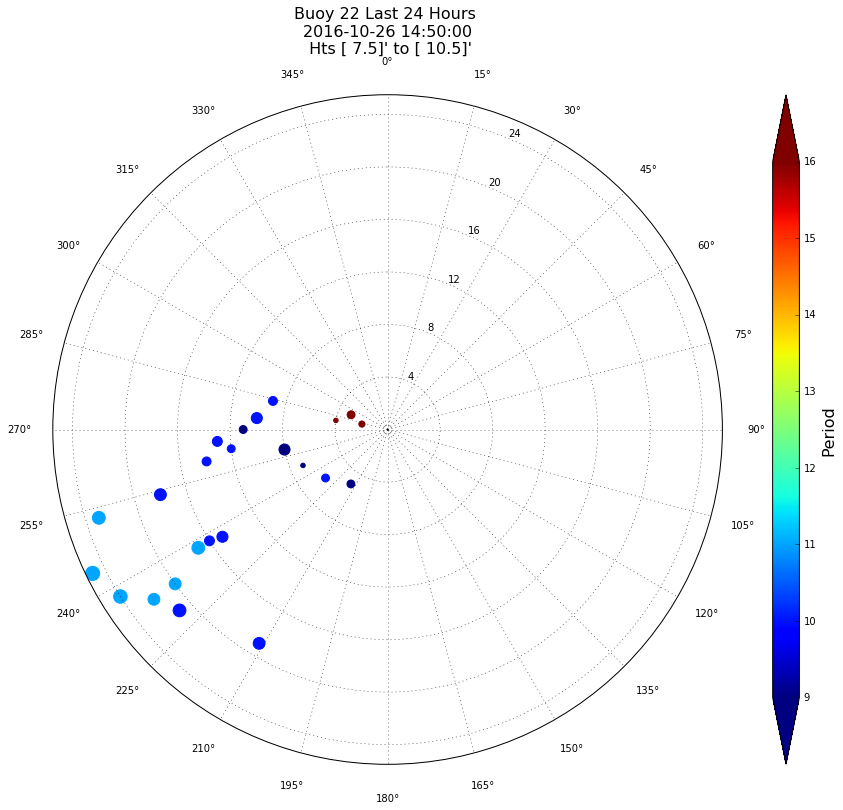

In [9]:
plt.rcParams['figure.figsize'] =[18, 12]

ax = plt.subplot(111, projection='polar')
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi/2)
theta_tics = np.arange(0, 360, 15)
ax.set_thetagrids(theta_tics)
ax.set_rlim([0, 25.5])
r_tics = np.arange(4, 28, 4)
ax.set_rgrids(r_tics)
ax.grid(True)

p = ax.scatter(theta, r, s=pnt_sz, c=period, edgecolors='face')#color='r', linewidth=3)
cbar = plt.colorbar(p, extend='both', extendfrac=0.125)
cbar.set_label('Period', fontsize=16)
cbar.set_ticks(np.arange(period.min(), period.max() + 1))

ax.set_title(tlt_str, va='bottom', fontsize=16)

plt.show(ax)